In [278]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns


results_dir = "results"
eval_acc_path = os.path.join(results_dir, "lora_plus_eval_accuracy.csv")
eval_f1_path = os.path.join(results_dir, "lora_plus_eval_f1.csv")
eval_runtime_path = os.path.join(results_dir, "lora_plus_eval_runtime.csv")
gpu_mem_path = os.path.join(results_dir, "lora_plus_gpu_peak_mem_mb.csv")
train_runtime_path = os.path.join(results_dir, "lora_plus_time_train_runtime_s.csv")
train_loss_path = os.path.join(results_dir, "lora_plus_train_loss.csv")


eval_acc_df = pd.read_csv(eval_acc_path)
eval_f1_df = pd.read_csv(eval_f1_path)
eval_runtime_df = pd.read_csv(eval_runtime_path)
gpu_mem_df = pd.read_csv(gpu_mem_path)
train_runtime_df = pd.read_csv(train_runtime_path)
train_loss_df = pd.read_csv(train_loss_path)

In [282]:
train_loss_df.columns[:13]

Index(['train/global_step',
       'loraplus_alpha_16_r_64_lr_A_1e-4_lr_B_4e-4 - _step',
       'loraplus_alpha_16_r_64_lr_A_1e-4_lr_B_4e-4 - _step__MIN',
       'loraplus_alpha_16_r_64_lr_A_1e-4_lr_B_4e-4 - _step__MAX',
       'loraplus_alpha_16_r_64_lr_A_1e-4_lr_B_4e-4 - train/loss',
       'loraplus_alpha_16_r_64_lr_A_1e-4_lr_B_4e-4 - train/loss__MIN',
       'loraplus_alpha_16_r_64_lr_A_1e-4_lr_B_4e-4 - train/loss__MAX',
       'loraplus_alpha_16_r_64_lr_A_1e-4_lr_B_2e-4 - _step',
       'loraplus_alpha_16_r_64_lr_A_1e-4_lr_B_2e-4 - _step__MIN',
       'loraplus_alpha_16_r_64_lr_A_1e-4_lr_B_2e-4 - _step__MAX',
       'loraplus_alpha_16_r_64_lr_A_1e-4_lr_B_2e-4 - train/loss',
       'loraplus_alpha_16_r_64_lr_A_1e-4_lr_B_2e-4 - train/loss__MIN',
       'loraplus_alpha_16_r_64_lr_A_1e-4_lr_B_2e-4 - train/loss__MAX'],
      dtype='object')

### Eval acc

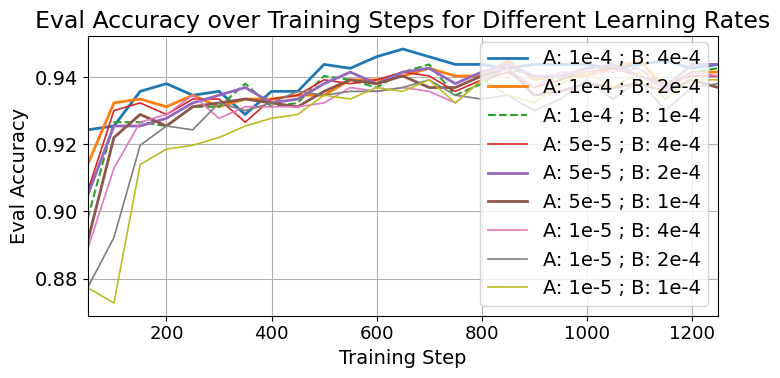

In [279]:
# Identify eval accuracy columns using regex
accuracy_cols = [col for col in eval_acc_df.columns if col.endswith("eval/accuracy")]

# Initialize a dictionary to hold data for plotting
plot_data = {}

# Inside your loop where you plot each experiment
def get_style(ratio: float) -> dict:
    # Define styles for different ratio groups
    style_map = {
        1: {'linestyle': '--', 'linewidth': 1.5},
        'medium': {'linestyle': '-', 'linewidth': 2},   # ratios 2, 4
        'high': {'linestyle': '-', 'linewidth': 1.2}       # ratios 8, 10, 20, 40
    }

    if ratio == 1:
        style = style_map[1]
    elif ratio in [2, 4]:
        style = style_map['medium']
    else:  # for 8, 10, 20, 40
        style = style_map['high']

    return style


# Extract accuracy data and corresponding steps
for col in accuracy_cols:
    match = re.search(r'lr_A_([\deE.-]+)_lr_B_([\deE.-]+)', col)
    if match:
        lr_A, lr_B = match.groups()
        label = f"A: {lr_A} ; B: {lr_B}"
        step_col = col.replace("eval/accuracy", "_step")
        if step_col in eval_acc_df.columns:
            steps = eval_acc_df[step_col]
            accuracy = eval_acc_df[col]
            style = get_style(float(lr_B) / float(lr_A))
            plot_data[label] = (steps, accuracy, style)

# Plotting
plt.figure(figsize=(7.5, 4))
for label, (steps, accuracy, style) in plot_data.items():
    line, = plt.plot(steps, accuracy, label=label, **style)
    line_color = line.get_color()
    
    # Add a thick circle marker where max accuracy is first reached
    max_idx = accuracy.idxmax()
    max_step = steps[max_idx]
    max_f1 = accuracy[max_idx]
    # plt.plot(max_step, max_acc, '.', markersize=8, markeredgewidth=2, markeredgecolor=line_color, markerfacecolor='none')


plt.xlim(eval_acc_df['train/global_step'].min(), eval_acc_df['train/global_step'].max())
plt.xlabel("Training Step")
plt.ylabel("Eval Accuracy")
plt.title("Eval Accuracy over Training Steps for Different Learning Rates")
plt.legend(loc='lower right')
plt.tight_layout()
plt.grid(True)
plt.show()

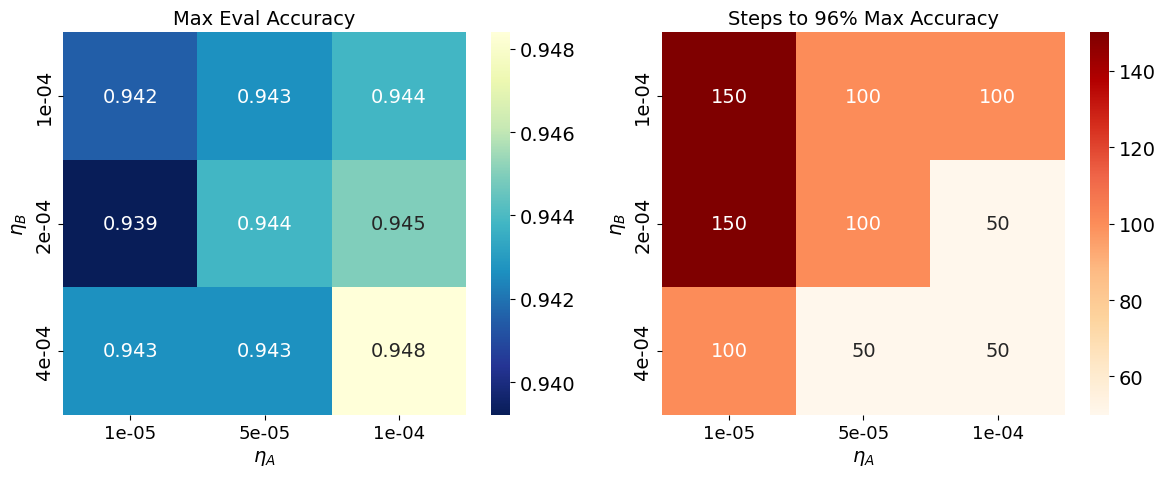

In [280]:
accuracy_cols = [col for col in eval_acc_df.columns if col.endswith("eval/accuracy")]

# Get sorted unique learning rates
lr_As = sorted({float(re.search(r'lr_A_([\deE.-]+)', col).group(1)) for col in accuracy_cols})
lr_Bs = sorted({float(re.search(r'lr_B_([\deE.-]+)', col).group(1)) for col in accuracy_cols})

# Initialize 2D arrays for heatmaps
max_acc_grid = np.full((3, 3), np.nan)
steps_90_grid = np.full((3, 3), np.nan)

# Fill in values
threshold = 0.96
for col in accuracy_cols:
    match = re.search(r'lr_A_([\deE.-]+)_lr_B_([\deE.-]+)', col)
    if match:
        lr_A, lr_B = map(float, match.groups())
        row = lr_Bs.index(lr_B)
        col_idx = lr_As.index(lr_A)

        acc = eval_acc_df[col].values
        step_col = col.replace("eval/accuracy", "_step")
        steps = eval_acc_df[step_col].values

        max_acc = np.max(acc)
        max_acc_grid[row, col_idx] = max_acc

        # Step at which accuracy first exceeds 90% of max
        above_thresh = np.where(acc >= threshold * max_acc)[0]
        if above_thresh.size > 0:
            steps_90_grid[row, col_idx] = steps[above_thresh[0]]



fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Convert learning rates to scientific notation strings
xtick_labels = [f"{x:.0e}" for x in lr_As]
ytick_labels = [f"{y:.0e}" for y in lr_Bs]

# Heatmap of max accuracy
sns.heatmap(max_acc_grid, annot=True, fmt=".3f", xticklabels=xtick_labels, yticklabels=ytick_labels,
            cmap="YlGnBu_r", ax=axes[0])
axes[0].set_title("Max Eval Accuracy", fontsize=14)
axes[0].set_xlabel("$\\eta_A$", fontsize=14)
axes[0].set_ylabel("$\\eta_B$", fontsize=14)

# Heatmap of steps to 90% of max accuracy
sns.heatmap(steps_90_grid, annot=True, fmt=".0f", xticklabels=xtick_labels, yticklabels=ytick_labels,
            cmap="OrRd", ax=axes[1])
axes[1].set_title(f"Steps to {threshold:.0%} Max Accuracy", fontsize=14)
axes[1].set_xlabel("$\\eta_A$", fontsize=14)
axes[1].set_ylabel("$\\eta_B$", fontsize=14)

plt.tight_layout()
plt.show()

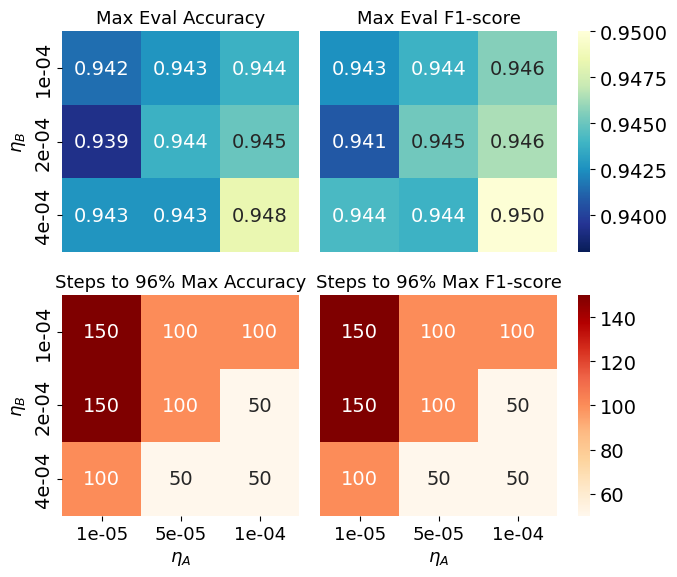

In [285]:
f1_cols = [col for col in eval_f1_df.columns if col.endswith("eval/f1")]

def plot_heatmap(ax, data, title, fmt, cmap, xticks, yticks, vmin=None, vmax=None, cbar_ax=None, cbar=False, set_xlabel=True, set_ylabel=True):
    sns.heatmap(data, annot=True, fmt=fmt, xticklabels=xticks, yticklabels=yticks, cmap=cmap, ax=ax, vmin=vmin, vmax=vmax, cbar_ax=cbar_ax, cbar=cbar)
    ax.set_title(title, fontsize=13)
    set_xlabel and ax.set_xlabel("$\\eta_A$", fontsize=13)
    set_ylabel and ax.set_ylabel("$\\eta_B$", fontsize=13)


# Compute F1-score grids (similar to how you did for accuracy)
max_f1_grid = np.full((len(lr_Bs), len(lr_As)), np.nan)
steps_90_f1_grid = np.full((len(lr_Bs), len(lr_As)), np.nan)

threshold = 0.96
for col in f1_cols:
    match = re.search(r"lr_A_([\deE.-]+)_lr_B_([\deE.-]+)", col)
    if match:
        lr_A, lr_B = map(float, match.groups())
        row = lr_Bs.index(lr_B)
        col_idx = lr_As.index(lr_A)

        f1 = eval_f1_df[col].values
        # step_col = col.replace("eval/f1", "Step")
        steps = eval_f1_df["Step"].values

        max_f1 = np.max(f1)
        max_f1_grid[row, col_idx] = max_f1

        # Step at which accuracy first exceeds 90% of max
        # print(threshold * max_f1, np.where(f1 >= threshold * max_f1)[0])
        # print(np.where(f1 >= threshold * max_f1)[0])
        above_thresh = np.where(f1 >= threshold * max_f1)[0]
        if above_thresh.size > 0:
            steps_90_f1_grid[row, col_idx] = steps[above_thresh[0]]

# Plotting 2x2 heatmaps
xtick_labels = [f"{x:.0e}" for x in lr_As]
ytick_labels = [f"{y:.0e}" for y in lr_Bs]

# Create gridspec layout for shared colorbars
fig = plt.figure(figsize=(7, 6))
gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 0.05])  # 2x2 plots + 1 shared colorbar per row

# Axes
ax00 = fig.add_subplot(gs[0, 0])  # Max Accuracy
ax01 = fig.add_subplot(gs[0, 1])  # Steps to 90% Accuracy
ax10 = fig.add_subplot(gs[1, 0])  # Max F1
ax11 = fig.add_subplot(gs[1, 1])  # Steps to 90% F1

# Colorbar axes (only one per row)
cbar_ax0 = fig.add_subplot(gs[0, 2])  # for accuracy row
cbar_ax1 = fig.add_subplot(gs[1, 2])  # for F1 row

# Accuracy plots
plot_heatmap(
    ax00, max_acc_grid, "Max Eval Accuracy", ".3f", "YlGnBu_r", [], ytick_labels, vmin=0.938, vmax=0.950, cbar_ax=cbar_ax0, set_xlabel=False
)
plot_heatmap(
    ax10,
    steps_90_grid,
    f"Steps to {threshold:.0%} Max Accuracy",
    ".0f",
    "OrRd",
    xtick_labels,
    ytick_labels, cbar_ax=cbar_ax1
)

# F1-score plots
plot_heatmap(ax01, max_f1_grid, "Max Eval F1-score", ".3f", "YlGnBu_r", [], [], vmin=0.938, vmax=0.950, cbar_ax=cbar_ax0, cbar=True, set_xlabel=False, set_ylabel=False)
plot_heatmap(
    ax11,
    steps_90_f1_grid,
    f"Steps to {threshold:.0%} Max F1-score",
    ".0f",
    "OrRd",
    xtick_labels,
    [], cbar_ax=cbar_ax1, cbar=True, set_ylabel=False,
)

plt.tight_layout()
plt.savefig("plots/lora_plus_eval_accuracy_f1_heatmaps.pdf", bbox_inches="tight")
plt.show()

C:\Users\popas\AppData\Local\Temp\ipykernel_12972\2514972482.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("rainbow")


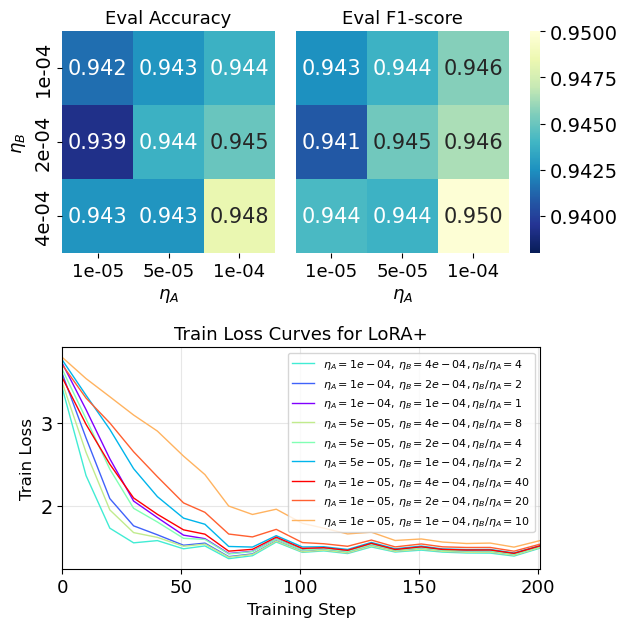

In [ ]:
plt.rcdefaults()
plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 13,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "axes.titlesize": 17,
})



f1_cols = [col for col in eval_f1_df.columns if col.endswith("eval/f1")]

def plot_heatmap(ax, data, title, fmt, cmap, xticks, yticks, vmin=None, vmax=None, cbar_ax=None, cbar=False, set_xlabel=True, set_ylabel=True):
    sns.heatmap(data, annot=True, fmt=fmt, xticklabels=xticks, yticklabels=yticks, cmap=cmap, ax=ax, vmin=vmin, vmax=vmax, cbar_ax=cbar_ax, cbar=cbar, annot_kws={"size": 15})
    ax.set_title(title, fontsize=13)
    set_xlabel and ax.set_xlabel("$\\eta_A$", fontsize=13)
    set_ylabel and ax.set_ylabel("$\\eta_B$", fontsize=13)


# Compute F1-score grids (similar to how you did for accuracy)
max_f1_grid = np.full((len(lr_Bs), len(lr_As)), np.nan)
steps_90_f1_grid = np.full((len(lr_Bs), len(lr_As)), np.nan)

threshold = 0.96
for col in f1_cols:
    match = re.search(r"lr_A_([\deE.-]+)_lr_B_([\deE.-]+)", col)
    if match:
        lr_A, lr_B = map(float, match.groups())
        row = lr_Bs.index(lr_B)
        col_idx = lr_As.index(lr_A)

        f1 = eval_f1_df[col].values
        # step_col = col.replace("eval/f1", "Step")
        steps = eval_f1_df["Step"].values

        max_f1 = np.max(f1)
        max_f1_grid[row, col_idx] = max_f1

        # Step at which accuracy first exceeds 90% of max
        # print(threshold * max_f1, np.where(f1 >= threshold * max_f1)[0])
        # print(np.where(f1 >= threshold * max_f1)[0])
        above_thresh = np.where(f1 >= threshold * max_f1)[0]
        if above_thresh.size > 0:
            steps_90_f1_grid[row, col_idx] = steps[above_thresh[0]]

# Plotting 2x2 heatmaps
xtick_labels = [f"{x:.0e}" for x in lr_As]
ytick_labels = [f"{y:.0e}" for y in lr_Bs]

# Create gridspec layout for shared colorbars
fig = plt.figure(figsize=(6.5, 6.5))
gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 0.05])  # 2x2 plots + 1 shared colorbar per row

# Axes
ax00 = fig.add_subplot(gs[0, 0])  # Max Accuracy
ax01 = fig.add_subplot(gs[0, 1])  # Steps to 90% Accuracy
cbar_ax0 = fig.add_subplot(gs[0, 2])  # for top row

# Merged bottom subplot and colorbar
ax10 = fig.add_subplot(gs[1, 0:3])  # Full-width for train loss

# Accuracy plots
plot_heatmap(
    ax00, max_acc_grid, "Eval Accuracy", ".3f", "YlGnBu_r", xtick_labels, ytick_labels, vmin=0.938, vmax=0.950, cbar_ax=cbar_ax0, set_xlabel=True
)
plot_heatmap(ax01, max_f1_grid, "Eval F1-score", ".3f", "YlGnBu_r", xtick_labels, [], vmin=0.938, vmax=0.950, cbar_ax=cbar_ax0, cbar=True, set_xlabel=True, set_ylabel=False)

lrs = []
for col in train_loss_df.columns:
    if col.endswith("train/loss"):
        match = re.search(r"lr_A_([\deE.-]+)_lr_B_([\deE.-]+)", col)
        if match:
            lr_A, lr_B = match.groups()
            lrs.append((float(lr_A), float(lr_B)))
lrs = sorted(set(lrs), key=lambda x: x[1] / x[0])

# Create a seaborn color palette from YlGnBu_r with as many colors as ranks
# primary_palette = sns.color_palette("YlGnBu", n_colors=len(lrs) + 1)
# primary_palette = sns.color_palette("Spectral", n_colors=len(lrs))
# primary_palette = sns.cubehelix_palette(
#     n_colors=len(lrs), 
#     start=0.9, 
#     rot=-0.75, 
#     dark=0.1, 
#     light=0.9, 
#     reverse=True
# )
from matplotlib.cm import get_cmap
cmap = get_cmap("rainbow")
primary_palette = [cmap(i / (len(lrs) - 1)) for i in range(len(lrs))]
# Map rank to a color
rank_to_color = {lr: color for lr, color in zip(lrs, primary_palette[-len(lrs):])}

for col in train_loss_df.columns:
    if col.endswith("train/loss"):
        match = re.search(r"lr_A_([\deE.-]+)_lr_B_([\deE.-]+)", col)
        if match:
            lr_A, lr_B = match.groups()
            label = f"$\\eta_A={float(lr_A):.0e}$, $\\eta_B={float(lr_B):.0e}, \\eta_B / \\eta_A = {int(float(lr_B) / float(lr_A))}$"
            loss = train_loss_df[col]
            step_col = col.replace("train/loss", "_step")
            if step_col in train_loss_df.columns:
                steps = train_loss_df[step_col]
                plt.plot(steps[:21], loss[:21], label=label, linewidth=1, alpha=1, color=rank_to_color[(float(lr_A), float(lr_B))])

# plt.yscale("log")
plt.xlim(steps.min(), steps[:21].max())
plt.xlabel("Training Step", fontsize=12)
plt.ylabel("Train Loss", fontsize=12)
plt.title("Train Loss Curves for LoRA+", fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=8, loc="upper right", frameon=True)
plt.tight_layout()
plt.savefig("plots/lora_plus_train_loss_curves.pdf", bbox_inches="tight")
plt.show()

### PiSSA

In [345]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns


results_dir = "results"
eval_acc_path = os.path.join(results_dir, "pissa_eval_accuracy.csv")
eval_f1_path = os.path.join(results_dir, "pissa_eval_f1.csv")
gpu_mem_path = os.path.join(results_dir, "pissa_gpu_peak_mem_mb.csv")
train_runtime_path = os.path.join(results_dir, "pissa_time_train_runtime_s.csv")
train_loss_path = os.path.join(results_dir, "pissa_train_loss.csv")


eval_acc_df = pd.read_csv(eval_acc_path)
eval_f1_df = pd.read_csv(eval_f1_path)
gpu_mem_df = pd.read_csv(gpu_mem_path)
train_runtime_df = pd.read_csv(train_runtime_path)
train_loss_df = pd.read_csv(train_loss_path)

print(train_loss_df.columns)

Index(['train/global_step', 'pissa_init_pissa_r_8_alpha_8_lr_5e-5 - _step',
       'pissa_init_pissa_r_8_alpha_8_lr_5e-5 - _step__MIN',
       'pissa_init_pissa_r_8_alpha_8_lr_5e-5 - _step__MAX',
       'pissa_init_pissa_r_8_alpha_8_lr_5e-5 - train/loss',
       'pissa_init_pissa_r_8_alpha_8_lr_5e-5 - train/loss__MIN',
       'pissa_init_pissa_r_8_alpha_8_lr_5e-5 - train/loss__MAX',
       'pissa_init_pissa_r_4_alpha_4_lr_5e-5 - _step',
       'pissa_init_pissa_r_4_alpha_4_lr_5e-5 - _step__MIN',
       'pissa_init_pissa_r_4_alpha_4_lr_5e-5 - _step__MAX',
       'pissa_init_pissa_r_4_alpha_4_lr_5e-5 - train/loss',
       'pissa_init_pissa_r_4_alpha_4_lr_5e-5 - train/loss__MIN',
       'pissa_init_pissa_r_4_alpha_4_lr_5e-5 - train/loss__MAX',
       'pissa_init_pissa_r_2_alpha_2_lr_5e-5 - _step',
       'pissa_init_pissa_r_2_alpha_2_lr_5e-5 - _step__MIN',
       'pissa_init_pissa_r_2_alpha_2_lr_5e-5 - _step__MAX',
       'pissa_init_pissa_r_2_alpha_2_lr_5e-5 - train/loss',
       'pissa_

C:\Users\popas\AppData\Local\Temp\ipykernel_12972\503115646.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("rainbow")


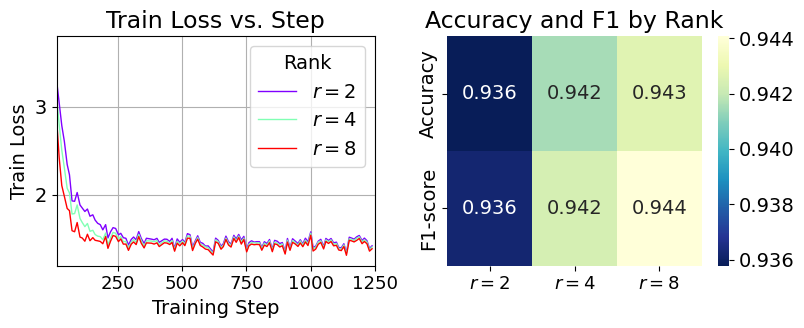

In [349]:
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcdefaults()
plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 13,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "axes.titlesize": 17,
})
# Identify loss columns
loss_cols = [col for col in train_loss_df.columns if col.endswith("train/loss")]

# Get unique ranks (sorted for consistency)
ranks = sorted(set(int(re.search(r'pissa_r_(\d+)', col).group(1)) for col in loss_cols))
# Create a seaborn color palette from YlGnBu_r with as many colors as ranks
# primary_palette = sns.color_palette("YlGnBu", n_colors=len(ranks) + 2)
from matplotlib.cm import get_cmap
cmap = get_cmap("rainbow")
primary_palette = [cmap(i / (len(ranks) - 1)) for i in range(len(ranks))]
# Map rank to a color
rank_to_color = {rank: color for rank, color in zip(ranks, primary_palette[-len(ranks) - 1:])}

# Identify loss columns
loss_cols = [col for col in train_loss_df.columns if col.endswith("train/loss")]

# Set up figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(8.5, 3.5), gridspec_kw={'width_ratios': [1, 1]})
ax1, ax2 = axs

# # Plotting
# plt.figure(figsize=(3.5, 2.75))
# ax1.set_facecolor("white")  # Set background color to light gray

for col in loss_cols[::-1]:
    match = re.search(r'pissa_r_(\d+)', col)
    if match:
        rank = match.group(1)
        step_col = col.replace("train/loss", "_step")
        if step_col in train_loss_df.columns:
            steps = train_loss_df[step_col]
            loss = train_loss_df[col]
            ax1.plot(steps, loss, label=f"$r={rank}$", 
                     color=rank_to_color[int(rank)], linewidth=1)

ax1.set_xlim(train_loss_df['train/global_step'].min(), train_loss_df['train/global_step'].max())
ax1.set_xlabel("Training Step")
ax1.set_ylabel("Train Loss")
ax1.set_title("Train Loss vs. Step")
ax1.legend(title="Rank")
ax1.grid(True)

# Plot 2: Heatmap of Max Accuracy and F1
acc_data = []
f1_data = []

for rank in ranks:
    acc_col = [col for col in eval_acc_df.columns if f'pissa_r_{rank}' in col and col.endswith("eval/accuracy")]
    f1_col = [col for col in eval_f1_df.columns if f'pissa_r_{rank}' in col and col.endswith("eval/f1")]

    acc_max = eval_acc_df[acc_col[0]].max() if acc_col else np.nan
    f1_max = eval_f1_df[f1_col[0]].max() if f1_col else np.nan

    acc_data.append(acc_max)
    f1_data.append(f1_max)

# Create heatmap data
heatmap_data = np.array([acc_data, f1_data])
heatmap_labels = ["Accuracy", "F1-score"]
rank_labels = [f"$r={r}$" for r in ranks]

sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu_r", cbar=True,
            xticklabels=rank_labels, yticklabels=heatmap_labels, ax=ax2)

ax2.set_title("Accuracy and F1 by Rank")

# plt.subplots_adjust(hspace=0.5, wspace=1)
plt.tight_layout()
plt.savefig("plots/pissa_train_loss_vs_step.pdf", bbox_inches="tight")
plt.show()


In [203]:
import matplotlib.font_manager
for font in matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf'):
    if "roman" in font.lower():
        print(font)

C:\Windows\Fonts\INFROMAN.TTF


### $BA$ init

In [397]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns


results_dir = "results"
eval_acc_path = os.path.join(results_dir, "ba_init_eval_acc.csv")
eval_f1_path = os.path.join(results_dir, "ba_init_eval_f1.csv")
train_loss_path = os.path.join(results_dir, "ba_init_train_loss.csv")
eval_acc_path_rest = os.path.join(results_dir, "ba_init_eval_acc_rest.csv")
eval_f1_path_rest = os.path.join(results_dir, "ba_init_eval_f1_rest.csv")
train_loss_path_rest = os.path.join(results_dir, "ba_init_train_loss_rest.csv")


eval_acc_df = pd.read_csv(eval_acc_path)
eval_f1_df = pd.read_csv(eval_f1_path)
train_loss_df = pd.read_csv(train_loss_path)
eval_acc_df_rest = pd.read_csv(eval_acc_path_rest)
eval_f1_df_rest = pd.read_csv(eval_f1_path_rest)
train_loss_df_rest = pd.read_csv(train_loss_path_rest)

eval_acc_df = pd.concat([eval_acc_df, eval_acc_df_rest], ignore_index=True)
eval_f1_df = pd.concat([eval_f1_df, eval_f1_df_rest], ignore_index=True)

print(eval_acc_df.columns)

Index(['train/global_step', 'tiny_bra_rank_16 - _step',
       'tiny_bra_rank_16 - _step__MIN', 'tiny_bra_rank_16 - _step__MAX',
       'tiny_bra_rank_16 - eval/accuracy',
       'tiny_bra_rank_16 - eval/accuracy__MIN',
       'tiny_bra_rank_16 - eval/accuracy__MAX', 'tiny_bra_rank_32 - _step',
       'tiny_bra_rank_32 - _step__MIN', 'tiny_bra_rank_32 - _step__MAX',
       'tiny_bra_rank_32 - eval/accuracy',
       'tiny_bra_rank_32 - eval/accuracy__MIN',
       'tiny_bra_rank_32 - eval/accuracy__MAX',
       'tiny_b_zero_a_uniform_rank_16 - _step',
       'tiny_b_zero_a_uniform_rank_16 - _step__MIN',
       'tiny_b_zero_a_uniform_rank_16 - _step__MAX',
       'tiny_b_zero_a_uniform_rank_16 - eval/accuracy',
       'tiny_b_zero_a_uniform_rank_16 - eval/accuracy__MIN',
       'tiny_b_zero_a_uniform_rank_16 - eval/accuracy__MAX',
       'tiny_b_zero_a_uniform_rank_32 - _step',
       'tiny_b_zero_a_uniform_rank_32 - _step__MIN',
       'tiny_b_zero_a_uniform_rank_32 - _step__MAX',
      

tiny_bra_rank_16 - eval/accuracy
R middle 16
2 3
tiny_bra_rank_32 - eval/accuracy
R middle 32
2 4
tiny_b_zero_a_uniform_rank_16 - eval/accuracy
A~U B=0 16
0 3
tiny_b_zero_a_uniform_rank_32 - eval/accuracy
A~U B=0 32
0 4
tiny_b_uniform_a_zero_rank_16 - eval/accuracy
A=0 B~U 16
1 3
tiny_b_uniform_a_zero_rank_32 - eval/accuracy
A=0 B~U 32
1 4
tiny_bra_rank_2 - eval/accuracy
R middle 2
2 0
tiny_bra_rank_4 - eval/accuracy
R middle 4
2 1
tiny_bra_rank_8 - eval/accuracy
R middle 8
2 2
tiny_b_zero_a_uniform_rank_2 - eval/accuracy
A~U B=0 2
0 0
tiny_b_zero_a_uniform_rank_4 - eval/accuracy
A~U B=0 4
0 1
tiny_b_zero_a_uniform_rank_8 - eval/accuracy
A~U B=0 8
0 2
tiny_b_uniform_a_zero_rank_2 - eval/accuracy
A=0 B~U 2
1 0
tiny_b_uniform_a_zero_rank_4 - eval/accuracy
A=0 B~U 4
1 1
tiny_b_uniform_a_zero_rank_8 - eval/accuracy
A=0 B~U 8
1 2


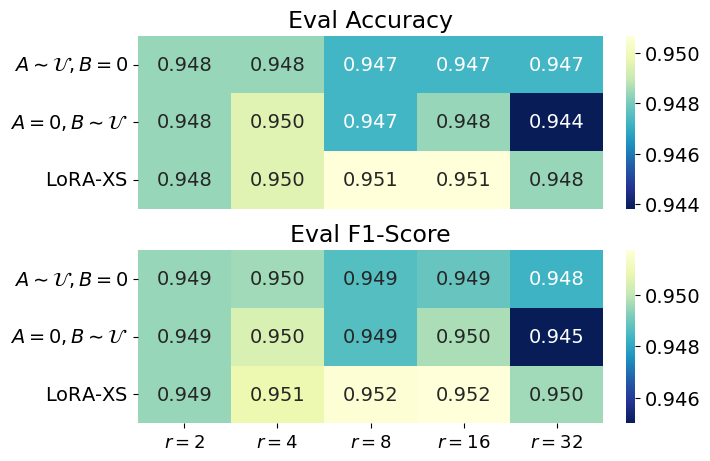

In [398]:
plt.rcdefaults()
plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 13,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "axes.titlesize": 17,
})


# Identify eval accuracy and f1 score columns
acc_cols = [col for col in eval_acc_df.columns if col.endswith("eval/accuracy")]
f1_cols = [col for col in eval_f1_df.columns if col.endswith("eval/f1")]

# Extract method and rank from column names
def extract_method_rank(col):
    method = "unknown"
    if "tiny_b_zero" in col:
        method = "A~U B=0"
    elif "tiny_b_uniform" in col:
        method = "A=0 B~U"
    elif "tiny_bra" in col:
        method = "R middle"
    rank_match = re.search(r'_rank_(\d+)', col)
    rank = int(rank_match.group(1)) if rank_match else -1
    return method, rank

# Create grid data
method_names = ["$A\sim\mathcal{U}, B=0$", "$A=0, B\sim\mathcal{U}$", "$\\text{LoRA-XS}$"]
methods = ["A~U B=0", "A=0 B~U", "R middle"]
ranks = [2, 4, 8, 16, 32]

acc_grid = np.full((3, 5), 0.0)
f1_grid = np.full((3, 5), 0.0)

for col in acc_cols:
    print(col)
    method, rank = extract_method_rank(col)
    print(method, rank)
    if method in methods and rank in ranks:
        row = methods.index(method)
        col_idx = ranks.index(rank)
        print(row, col_idx)
        acc_grid[row, col_idx] = eval_acc_df[col].max()

for col in f1_cols:
    method, rank = extract_method_rank(col)
    if method in methods and rank in ranks:
        row = methods.index(method)
        col_idx = ranks.index(rank)
        f1_grid[row, col_idx] = eval_f1_df[col].max()

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(7, 4.5), constrained_layout=True,
                         gridspec_kw={'height_ratios': [1, 1]})

cmap = sns.color_palette("YlGnBu_r", as_cmap=True)

# First subplot: Accuracy heatmap
sns.heatmap(acc_grid, annot=True, fmt=".3f", cmap=cmap, cbar=True,
            xticklabels=[], yticklabels=method_names, ax=axes[0], cbar_kws={})
axes[0].set_title("Eval Accuracy")
axes[0].tick_params(axis='x', bottom=False, top=False, labelbottom=False)

# Second subplot: F1 heatmap
sns.heatmap(f1_grid, annot=True, fmt=".3f", cmap=cmap, cbar=True,
            xticklabels=[f"$r={r}$" for r in ranks], yticklabels=method_names, ax=axes[1], cbar_kws={})
axes[1].set_title("Eval F1-Score")
axes[1].tick_params(axis='x', rotation=0)

plt.savefig("plots/ba_init_eval_acc_f1_heatmaps.pdf", bbox_inches="tight")
plt.show()


### Best / Conclusion

In [351]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns


results_dir = "results"
eval_acc_path = os.path.join(results_dir, "best_eval_acc.csv")
eval_f1_path = os.path.join(results_dir, "best_eval_f1.csv")
train_loss_path = os.path.join(results_dir, "best_train_loss.csv")
gpu_mem_path = os.path.join(results_dir, "best_gpu_peak_mem_mb.csv")
train_runtime_path = os.path.join(results_dir, "best_time_train_runtime_s.csv")

eval_acc_df = pd.read_csv(eval_acc_path)
eval_f1_df = pd.read_csv(eval_f1_path)
train_loss_df = pd.read_csv(train_loss_path)
gpu_mem_df = pd.read_csv(gpu_mem_path)
train_runtime_df = pd.read_csv(train_runtime_path)
print(train_loss_df.columns)

Index(['train/global_step', 'tiny_bra_rank_16 - _step',
       'tiny_bra_rank_16 - _step__MIN', 'tiny_bra_rank_16 - _step__MAX',
       'tiny_bra_rank_16 - train/loss', 'tiny_bra_rank_16 - train/loss__MIN',
       'tiny_bra_rank_16 - train/loss__MAX',
       'pissa_init_pissa_r_8_alpha_8_lr_5e-5 - _step',
       'pissa_init_pissa_r_8_alpha_8_lr_5e-5 - _step__MIN',
       'pissa_init_pissa_r_8_alpha_8_lr_5e-5 - _step__MAX',
       'pissa_init_pissa_r_8_alpha_8_lr_5e-5 - train/loss',
       'pissa_init_pissa_r_8_alpha_8_lr_5e-5 - train/loss__MIN',
       'pissa_init_pissa_r_8_alpha_8_lr_5e-5 - train/loss__MAX',
       'loraplus_alpha_16_r_64_lr_A_1e-4_lr_B_4e-4 - _step',
       'loraplus_alpha_16_r_64_lr_A_1e-4_lr_B_4e-4 - _step__MIN',
       'loraplus_alpha_16_r_64_lr_A_1e-4_lr_B_4e-4 - _step__MAX',
       'loraplus_alpha_16_r_64_lr_A_1e-4_lr_B_4e-4 - train/loss',
       'loraplus_alpha_16_r_64_lr_A_1e-4_lr_B_4e-4 - train/loss__MIN',
       'loraplus_alpha_16_r_64_lr_A_1e-4_lr_B_4e-4 - 

C:\Users\popas\AppData\Local\Temp\ipykernel_12972\2767508793.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("rainbow")


tiny_bra_rank_16 - _step tiny_bra_rank_16 - gpu_peak_mem_mb
loraplus_alpha_16_r_64_lr_A_1e-4_lr_B_4e-4 - _step loraplus_alpha_16_r_64_lr_A_1e-4_lr_B_4e-4 - gpu_peak_mem_mb
pissa_init_pissa_r_8_alpha_8_lr_5e-5 - _step pissa_init_pissa_r_8_alpha_8_lr_5e-5 - gpu_peak_mem_mb
tiny_b_zero_a_uniform_rank_4 - _step tiny_b_zero_a_uniform_rank_4 - gpu_peak_mem_mb
tiny_b_uniform_a_zero_rank_4 - _step tiny_b_uniform_a_zero_rank_4 - gpu_peak_mem_mb


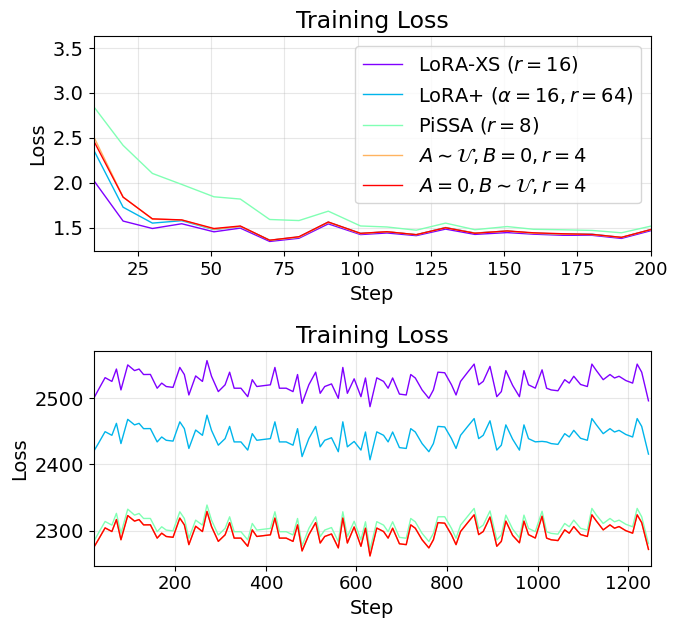

In [391]:
plt.rcdefaults()
plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 13,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "axes.titlesize": 17,
})

# Mapping from internal names to labels
method_map = {
    "tiny_bra_rank_16": "LoRA-XS ($r=16$)",
    "loraplus_alpha_16_r_64_lr_A_1e-4_lr_B_4e-4": "LoRA+ ($\\alpha=16, r=64$)",
    "pissa_init_pissa_r_8_alpha_8_lr_5e-5": "PiSSA ($r=8$)",
    "tiny_b_zero_a_uniform_rank_4": "$A\sim\mathcal{U}, B=0, r=4$",
    "tiny_b_uniform_a_zero_rank_4": "$A=0, B\sim\mathcal{U}, r=4$",
}

from matplotlib.cm import get_cmap
cmap = get_cmap("rainbow")
primary_palette = [cmap(i / (5 - 1)) for i in range(5)]
rank_to_color = {key: color for key, color in zip(method_map.keys(), primary_palette)}

# Plotting train loss and GPU memory
plt.figure(figsize=(7, 6.5))
# sns.set(style="whitegrid")

# --- First subplot: Train Loss ---
ax1 = plt.subplot(2, 1, 1)
ax1.grid(True, alpha=0.3)
for key, label in method_map.items():
    step_col = f"{key} - _step"
    loss_col = f"{key} - train/loss"
    if step_col in train_loss_df and loss_col in train_loss_df:
        steps = train_loss_df[step_col]
        loss = train_loss_df[loss_col]
        color = rank_to_color[key]
        ax1.plot(steps[:21], loss[:21], label=label, color=color, linewidth=1)

ax1.set_xlim(train_loss_df['train/global_step'].min(), train_loss_df['train/global_step'][:20].max())
ax1.set_title("Training Loss")
ax1.set_xlabel("Step")
ax1.set_ylabel("Loss")
ax1.legend()

# --- Second subplot: GPU Peak Memory ---
ax2 = plt.subplot(2, 1, 2)
ax2.grid(True, alpha=0.3)
gpu_values = []
labels = []

# # --- First subplot: Train Loss ---
# ax1 = plt.subplot(2, 1, 1)
# ax1.grid(True, alpha=0.3)
for key, label in method_map.items():
    step_col = f"{key} - _step"
    gpu_col = f"{key} - gpu_peak_mem_mb"
    print(step_col, gpu_col)
    if step_col in gpu_mem_df and gpu_col in gpu_mem_df:
        steps = gpu_mem_df[step_col]
        gpu = gpu_mem_df[gpu_col]
        color = rank_to_color[key]
        ax2.plot(steps, gpu, label=label, color=color, linewidth=1)

ax2.set_xlim(gpu_mem_df['train/global_step'].min(), gpu_mem_df['train/global_step'].max())
ax2.set_title("Training Loss")
ax2.set_xlabel("Step")
ax2.set_ylabel("Loss")
# ax2.legend()

# for key, label in method_map.items():
#     col_matches = [c for c in gpu_mem_df.columns if key in c and "gpu" in c]
#     if col_matches:
#         gpu_values.append(gpu_mem_df[col_matches[0]].values[0])
#         labels.append(label)

# sns.barplot(x=labels, y=gpu_values, ax=ax2, palette="YlOrBr")
# ax2.set_title("GPU Peak Memory (MB)")
# ax2.set_ylabel("Memory (MB)")
# ax2.set_xlabel("")
# ax2.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig("plots/train_loss_and_gpu_mem.pdf")
plt.show()


In [393]:
import pandas as pd
import os
import re

# Load data
results_dir = "results"
eval_acc_df = pd.read_csv(os.path.join(results_dir, "best_eval_acc.csv"))
eval_f1_df = pd.read_csv(os.path.join(results_dir, "best_eval_f1.csv"))
train_runtime_df = pd.read_csv(os.path.join(results_dir, "best_time_train_runtime_s.csv"))

# Mapping from internal keys to LaTeX table labels
method_map = {
    "tiny_bra_rank_16": "LoRA-XS (r=16)",
    "pissa_init_pissa_r_8_alpha_8_lr_5e-5": "PiSSA (r=8)",
    "loraplus_alpha_16_r_64_lr_A_1e-4_lr_B_4e-4": "LoRA+ (alpha=16, r=64)",
    "tiny_b_zero_a_uniform_rank_4": "A$\sim$U, B=0, r=4",
    "tiny_b_uniform_a_zero_rank_4": "A=0, B$\sim$U, r=4",
}

# Output storage
metrics = {
    "Eval Accuracy": [],
    "Eval F1": [],
    "Train Runtime (s)": [],
}

for key in method_map:
    # Eval Accuracy
    acc_cols = [c for c in eval_acc_df.columns if key in c and c.endswith("eval/accuracy")]
    acc_val = eval_acc_df[acc_cols[0]].max() if acc_cols else float("nan")
    metrics["Eval Accuracy"].append(f"{acc_val:.3f}")

    # Eval F1
    f1_cols = [c for c in eval_f1_df.columns if key in c and c.endswith("eval/f1")]
    f1_val = eval_f1_df[f1_cols[0]].max() if f1_cols else float("nan")
    metrics["Eval F1"].append(f"{f1_val:.3f}")

    # Runtime
    runtime_cols = [c for c in train_runtime_df.columns if key in c and "train_runtime" in c]
    runtime_val = train_runtime_df[runtime_cols[0]].values[0] if runtime_cols else float("nan")
    metrics["Train Runtime (s)"].append(f"{runtime_val:.0f}")

# Generate LaTeX table
headers = list(method_map.values())

print("\\begin{table}[h]")
print("\\centering")
print("\\begin{tabular}{l" + "c" * len(headers) + "}")
print("\\toprule")
print("Metric & " + " & ".join(headers) + " \\\\")
print("\\midrule")

for metric, values in metrics.items():
    print(f"{metric} & " + " & ".join(values) + " \\\\")

print("\\bottomrule")
print("\\end{tabular}")
print("\\caption{Evaluation metrics and training time for different initialization methods.}")
print("\\label{tab:eval_metrics}")
print("\\end{table}")


\begin{table}[h]
\centering
\begin{tabular}{lccccc}
\toprule
Metric & LoRA-XS (r=16) & PiSSA (r=8) & LoRA+ (alpha=16, r=64) & A$\sim$U, B=0, r=4 & A=0, B$\sim$U, r=4 \\
\midrule
Eval Accuracy & 0.951 & 0.943 & 0.948 & 0.948 & 0.950 \\
Eval F1 & 0.952 & 0.944 & 0.950 & 0.950 & 0.950 \\
Train Runtime (s) & 6232 & 4982 & 5051 & 4959 & 4952 \\
\bottomrule
\end{tabular}
\caption{Evaluation metrics and training time for different initialization methods.}
\label{tab:eval_metrics}
\end{table}


In [395]:
import pandas as pd
import os

# Load data
results_dir = "results"
eval_acc_df = pd.read_csv(os.path.join(results_dir, "best_eval_acc.csv"))
eval_f1_df = pd.read_csv(os.path.join(results_dir, "best_eval_f1.csv"))
train_runtime_df = pd.read_csv(os.path.join(results_dir, "best_time_train_runtime_s.csv"))

# Mapping from internal keys to LaTeX row labels
method_map = {
    "tiny_bra_rank_16": "LoRA-XS (r=16)",
    "pissa_init_pissa_r_8_alpha_8_lr_5e-5": "PiSSA (r=8)",
    "loraplus_alpha_16_r_64_lr_A_1e-4_lr_B_4e-4": "LoRA+ (alpha=16, r=64)",
    "tiny_b_zero_a_uniform_rank_4": "A$\\sim$U, B=0, r=4",
    "tiny_b_uniform_a_zero_rank_4": "A=0, B$\\sim$U, r=4",
}

# Create a DataFrame to hold the values
rows = []
for key, label in method_map.items():
    acc_cols = [c for c in eval_acc_df.columns if key in c and c.endswith("eval/accuracy")]
    acc_val = eval_acc_df[acc_cols[0]].max() if acc_cols else float("nan")

    f1_cols = [c for c in eval_f1_df.columns if key in c and c.endswith("eval/f1")]
    f1_val = eval_f1_df[f1_cols[0]].max() if f1_cols else float("nan")

    runtime_cols = [c for c in train_runtime_df.columns if key in c and "train_runtime" in c]
    runtime_val = train_runtime_df[runtime_cols[0]].values[0] if runtime_cols else float("nan")

    rows.append([label, f"{acc_val:.3f}", f"{f1_val:.3f}", f"{runtime_val:.0f}"])

# LaTeX table output
print("\\begin{table}[h]")
print("\\centering")
print("\\begin{tabular}{lccc}")
print("\\toprule")
print("Method & Eval Accuracy & Eval F1 & Train Runtime (s) \\\\")
print("\\midrule")

for row in rows:
    print(" & ".join(row) + " \\\\")

print("\\bottomrule")
print("\\end{tabular}")
print("\\caption{Evaluation metrics and training time for different initialization methods.}")
print("\\label{tab:eval_metrics_transposed}")
print("\\end{table}")


\begin{table}[h]
\centering
\begin{tabular}{lccc}
\toprule
Method & Eval Accuracy & Eval F1 & Train Runtime (s) \\
\midrule
LoRA-XS (r=16) & 0.951 & 0.952 & 6232 \\
PiSSA (r=8) & 0.943 & 0.944 & 4982 \\
LoRA+ (alpha=16, r=64) & 0.948 & 0.950 & 5051 \\
A$\sim$U, B=0, r=4 & 0.948 & 0.950 & 4959 \\
A=0, B$\sim$U, r=4 & 0.950 & 0.950 & 4952 \\
\bottomrule
\end{tabular}
\caption{Evaluation metrics and training time for different initialization methods.}
\label{tab:eval_metrics_transposed}
\end{table}
